Name: Justin Chen

RIN: 662038816

[Kaggle competition url](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)

## Summary

The challenge of this Kaggle competition is to predict sales of various product families in Favorite stores across Ecuador, using a time-series dataset that incorporates multiple features. The dataset includes store, product, and promotion information, as well as other supplementary data such as oil prices and holiday details, which may affect sales trends. The goal is to predict future sales for each product family for a 15-day period following the last date in the training dataset.

**Class Label Descriptions**

| Feature name | Description                                                                                |
| ------------ | ------------------------------------------------------------------------------------------ |
| date         | The date for each sales record in the time series                                          |
| store_nbr    | Identifier for each store where sales are recorded                                         |
| family       | Type of product sold                                                                       |
| sales        | The target variable, showing number of units sold. This is the label for the predictions   |
| onpromotion  | The number of items under promotion in a aprticular product family for that date and store |
| city         | City where the store is located                                                            |
| state        | State where the store is located                                                           |
| type         | Type of store, providing categorical context                                               |
| cluster      | Store cluster, indicating a group of similar stores                                        |
| oil_price    | The daily oil price, a main driver for sale prices in Ecuador's economy                    |

**Preprocessing Techniques**

The preprocessing steps involve:

- **Date Processing**: Splitting the `date` column into separate year, month, and day features, or creating features like day of the week or holidays for better temporal analysis.
- **Handling Missing Values**: Filling missing values in `oil.csv`, as oil prices are critical for certain analyses.
- **One-Hot Encoding**: Encoding categorical features such as `store_nbr`, `family`, `city`, `state`, `type`, and `cluster` to facilitate machine learning models.
- **Scaling**: Normalizing the `sales` and `onpromotion` columns, as they exhibit a high variance across different stores and product families.
- **Holiday Adjustments**: Merging `holidays_events.csv` with the main dataset to identify dates with holidays, transferred holidays, and bridge days, which might affect sales.


**Initial Observations**

- **Sales Trends**: Initial analysis may reveal seasonality and trends associated with certain `family` types, promotion days, and holidays.
- **External Influences**: Variables like `oil_price` are expected to have correlations with sales, as fluctuations in oil prices can impact consumer purchasing power in Ecuador.
- **Store Clustering**: The `cluster` feature groups similar stores, which could help in creating models specific to each cluster, improving prediction accuracy.
- **Holidays and Events**: Holidays, especially transferred and bridge days, introduce unique sales patterns that need careful analysis.

## Benchmarking of Other Solutions

| Author                 | Features Used                                                       | Modeling Approach                                                                          | Score (Public LB) | Notes on Success                                                                                                                                                                                                                                                                                                                                                                                                                         |
| ---------------------- | ------------------------------------------------------------------- | ------------------------------------------------------------------------------------------ | ----------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **LenzDu (5th Place)** | Sales history, promotional info, categorical embeddings, oil prices | Ensemble of Gradient Boosting (LightGBM), CNN+DNN, and seq2seq RNN with weighted averaging | Top 1%            | Utilizes both traditional ML (LightGBM) and deep learning (CNN+DNN and seq2seq RNN) with dilated causal convolution, inspired by WaveNet. This hybrid approach capitalizes on the strengths of different architectures for robust, accurate predictions<br><br>[Kaggle](https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/discussion/41976])<br>[Github](https://github.com/LenzDu/Kaggle-Competition-Favorita)<br> |
| **Arthur Suilin**      | Sales, promotions, item, store, oil price                           | LightGBM model                                                                             | Top 2%            | Focuses on feature engineering and data imputation, creating key lag features and adjusting outliers for stable predictions. Efficient, with high interpretability, suitable for long-range time series prediction​<br><br>[Github](https://github.com/eyalshub/Favorita-Kaggle)                                                                                                                                                         |
| kaggleslayer           | Sales data, promotions, holiday info, store types                   | Neural Network with 3 hidden layers                                                        | N/A               | Uses a simple neural network that shows effectiveness with hyperparameter tuning and normalization, helping balance the model complexity with predictive capability. Suitable for fast computation​<br><br>[Kaggle](https://www.kaggle.com/code/kaggleslayer/grocery-prediction-with-neural-network)                                                                                                                                     |

## Data Description and Initial Processing

In [15]:
# Inital Processing

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load the datasets
train_df = pd.read_csv('train.csv')
stores_df = pd.read_csv('stores.csv')
oil_df = pd.read_csv('oil.csv')
holidays_df = pd.read_csv('holidays_events.csv')

# Convert date columns to datetime format for easier manipulation
train_df['date'] = pd.to_datetime(train_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# Step 1: Handle Missing Values
# Oil price data often has missing values, which we will forward-fill as oil price is continuous time series data.
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].ffill()

# Step 2: Merge datasets for additional insights
train_df = train_df.merge(stores_df, on='store_nbr', how='left')
train_df = train_df.merge(oil_df, on='date', how='left')
train_df = train_df.merge(holidays_df[['date', 'type', 'transferred']], on='date', how='left')

# Step 3: Feature Engineering
# Extract date-related features
train_df['day_of_week'] = train_df['date'].dt.dayofweek  # Monday=0, Sunday=6
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year

# Step 4: Handle any remaining missing values (if necessary)
# If there are any missing values remaining after the merges, fill with a placeholder or mean as appropriate
train_df.fillna({'dcoilwtico': train_df['dcoilwtico'].mean(), 'type': 'NoHoliday', 'transferred': 'False'}, inplace=True)

train_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,transferred,day_of_week,month,year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,67.932934,Holiday,False,1,1,2013
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,67.932934,Holiday,False,1,1,2013
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,67.932934,Holiday,False,1,1,2013
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,67.932934,Holiday,False,1,1,2013
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,67.932934,Holiday,False,1,1,2013


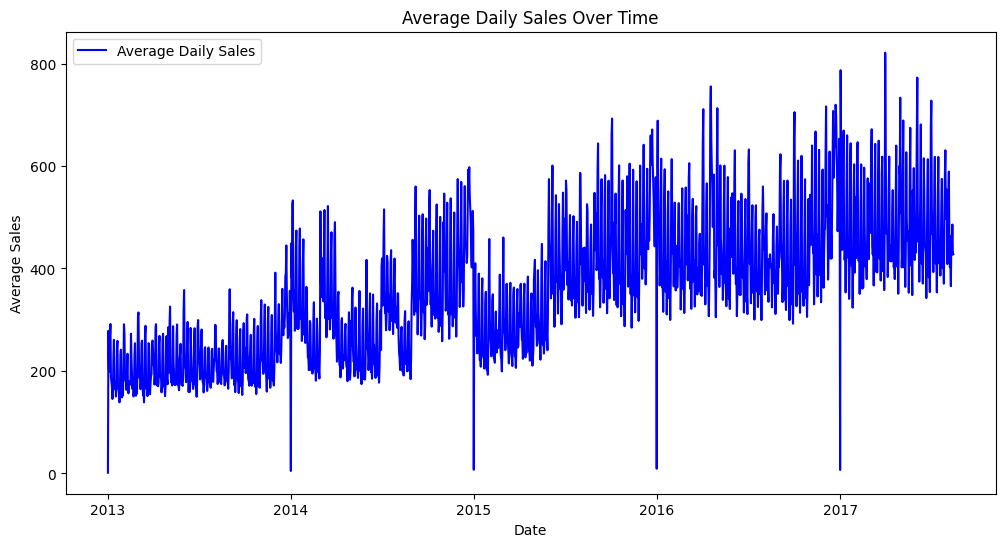

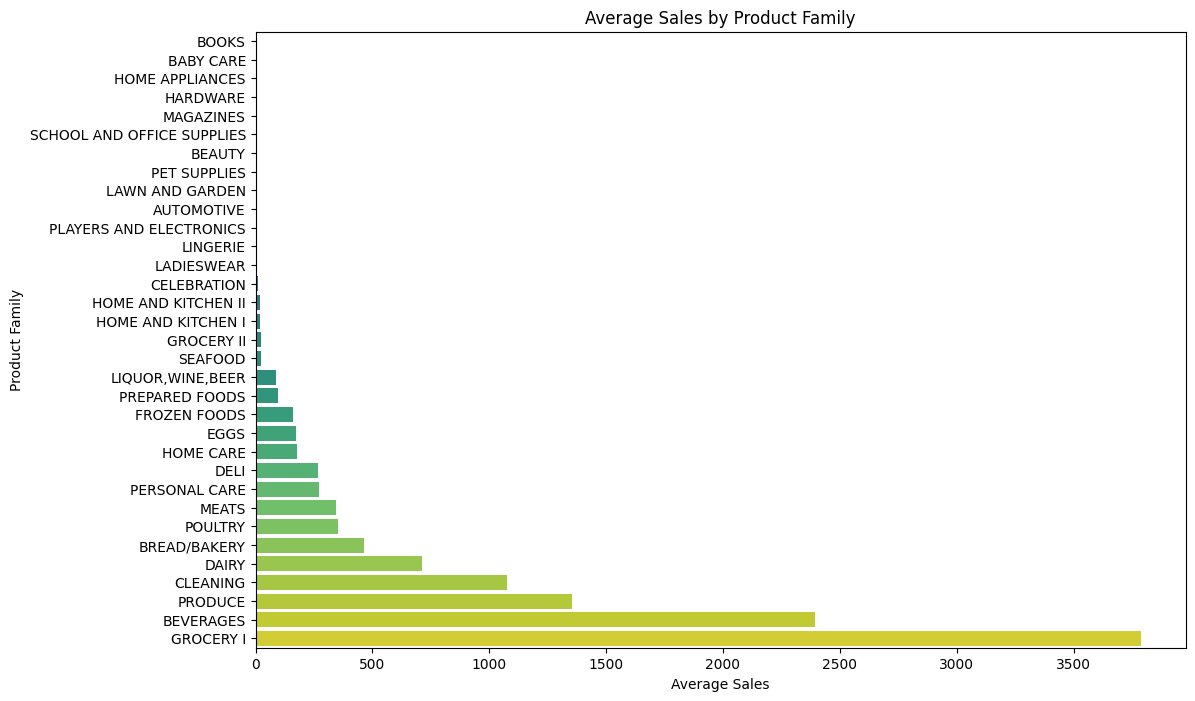

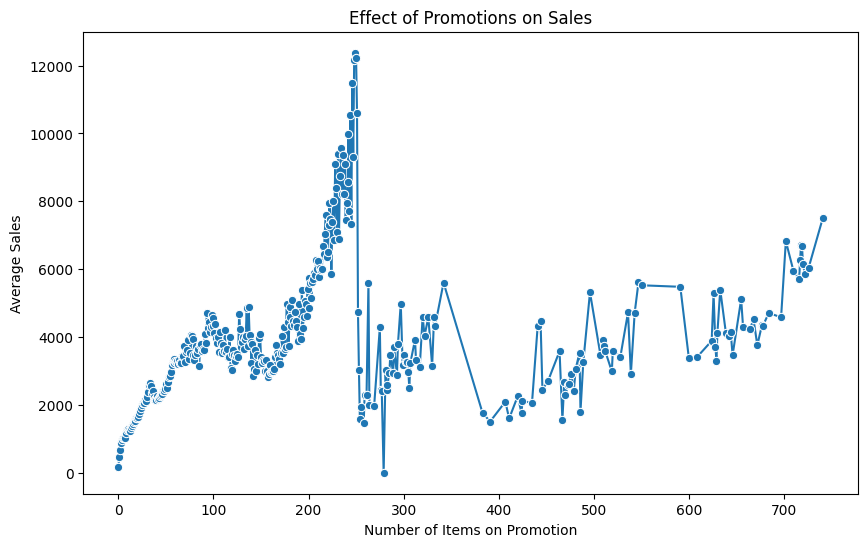

In [11]:
# Data Visualization

# 1. Time Series Plot of Average Daily Sales
daily_sales = train_df.groupby('date')['sales'].mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_sales, color='b', label='Average Daily Sales')
plt.title('Average Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend()
plt.show()

# 2. Bar Chart of Average Sales by Product Family
family_sales = train_df.groupby('family')['sales'].mean().sort_values()

plt.figure(figsize=(12, 8))
sns.barplot(x=family_sales, y=family_sales.index, palette="viridis", hue=family_sales.index, legend=False)
plt.title('Average Sales by Product Family')
plt.xlabel('Average Sales')
plt.ylabel('Product Family')
plt.show()

# 3. Sales vs. Promotions Analysis
promo_sales = train_df.groupby('onpromotion')['sales'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=promo_sales.index, y=promo_sales.values, marker='o')
plt.title('Effect of Promotions on Sales')
plt.xlabel('Number of Items on Promotion')
plt.ylabel('Average Sales')
plt.show()